In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification  -d  dataset  

Streaming output truncated to the last 5000 lines.
  inflating: dataset/seg_train/seg_train/mountain/7506.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7537.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7539.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7551.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7560.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7565.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7578.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7581.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7586.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7647.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7652.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7654.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7662.jpg  
  inflating: dataset/seg_train/seg_train/mountain/767.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7672.jpg  
  inflating: dataset/seg_train/seg_

#Loading dataset

In [29]:
train_dir = '/content/dataset/seg_train/seg_train'
test_dir = '/content/dataset/seg_test/seg_test'
BATCH_SIZE = 32

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      #  transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.4302, 0.4575, 0.4538],[0.2606, 0.2588, 0.2907],inplace = True)])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.4302, 0.4575, 0.4538],[0.2606, 0.2588, 0.2907],inplace = True)])


train_ds = datasets.ImageFolder(root=train_dir,transform=train_transforms)
test_ds = datasets.ImageFolder(root=test_dir,transform=test_transforms)

In [30]:
train_loader = DataLoader(dataset = train_ds,batch_size = BATCH_SIZE,shuffle = True,num_workers=2,pin_memory=True,drop_last=True)

test_loader = DataLoader(dataset = test_ds,batch_size = BATCH_SIZE,num_workers=2, pin_memory=True,drop_last=True)

# Utility Functions

In [31]:
def validation(model: torch.nn.modules.module,
               val_loader:torch.utils.data.dataloader,
               loss_fn: torch.nn.modules.loss) -> float:
  '''
  compute validation loss with corresponding model and loss function
  return validation loss
  '''

  model.eval()
  total_loss = 0 
  with torch.no_grad():
    for data, targets in tqdm(val_loader, desc= 'Validation'):
      data = data.to(device)
      targets = targets.to(device)

      scores = model(data)

      loss = loss_fn(scores,targets)
      total_loss += loss.item()
  model.train()
  return total_loss / len(val_loader)


In [40]:
def training(model: torch.nn.modules.module,
             train_dataset: torch.utils.data.dataloader,
             val_dataset: torch.utils.data.dataloader,
             criterion: torch.nn.modules.loss,
             optimizer:torch.optim,
             scheduler=None,
             epochs: int = 5) -> tuple:


  '''
  train model with given train set and optimizer
  return train and validation losses
  '''
  train_losses = []
  val_losses = []
  model.train()

  for epoch in tqdm(range(epochs) ):

    for  data, targets in tqdm(train_dataset,desc = f'Epoch {epoch + 1}'):
      # convert data and target to device
      data = data.to(device)
      targets = targets.to(device)

      # forward pass
      scores = model(data)
      loss = criterion(scores,targets)

      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()
      
    if scheduler is not None:
      scheduler.step()

    #validation
    val_loss = validation(model,val_dataset,criterion)
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    print(f'Train Loss: {np.mean(train_losses):.2f}, ',end = '')
    print(f'Validation Loss: {np.mean(val_losses):.2f}')

  return train_losses, val_losses

In [33]:
def inference(model: torch.nn.modules.module,
              test_dataset: torch.utils.data.dataloader) -> float:

  '''
  inference model on test set
  return test accuracy
  '''

  n_samples = 0
  n_correct = 0
  model.eval()

  with torch.no_grad():
    for data, targets in tqdm(test_dataset):
      data = data.to(device)
      targets = targets.to(device)

      scores = model(data)
      _, preds = scores.max(1)
      n_correct += (preds == targets).sum().item()
      n_samples += targets.size(0)

    return n_correct / n_samples

In [34]:
def save_checkpoint(best_acc, model,model_name, optimizer, epoch):
    print('Best Model Saving...')
    
    model_state_dict = model.state_dict()

    torch.save({
        'model_state_dict': model_state_dict,
        'global_epoch': epoch,
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc,
    }, os.path.join('checkpoints', f'checkpoint_{model_name}.pth'))

In [35]:
def compute_confusion_matrix(model,test_dataset):
  model.eval()
  predicted = []
  labels = []
  with torch.no_grad():
    for data, targets in(test_dataset):
      data = data.to(device)
      
      scores = model(data)
      _, preds = scores.max(1)
      predicted = np.concatenate((predicted,preds.cpu().numpy()))
      labels = np.concatenate((labels,targets.cpu().numpy()))
      
  model.train()

  confusion_mat = confusion_matrix(labels,predicted,normalize = 'true')
  fig, ax = plt.subplots(figsize=(15,15))
  ConfusionMatrixDisplay(confusion_mat, display_labels=test_dataset.dataset.classes).plot(xticks_rotation= 'vertical', ax = ax,colorbar = False, cmap =plt.cm.Blues)
  # plt.savefig('confusion_matrix.jpg')
  

In [36]:
num_classes = len(train_loader.dataset.classes)
learning_rate = 0.1
momentum = 0.9
EPOCHS = 15

# BoTNet

In [37]:
from model import Block, BoTNet50,BoTNet

botnet = BoTNet(Block, [3, 4, 6, 3], in_channels=3, num_classes=num_classes, shape=(224,224), heads=4)
botnet.to(device)

BoTNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
   

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(botnet.parameters(), lr=learning_rate, weight_decay=1e-4, momentum=momentum)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.0001)

In [39]:
train_losses, val_losses = training(botnet,train_loader,test_loader,criterion ,optimizer,lr_scheduler,epochs= 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.88, Validation Loss: 1.76


Epoch 2:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.75, Validation Loss: 1.65


Epoch 3:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.72, Validation Loss: 1.59


Epoch 4:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.63, Validation Loss: 1.54


Epoch 5:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.58, Validation Loss: 1.48


Epoch 6:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.48, Validation Loss: 1.43


Epoch 7:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.43, Validation Loss: 1.41


Epoch 8:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.42, Validation Loss: 1.47


Epoch 9:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.40, Validation Loss: 1.46


Epoch 10:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.38, Validation Loss: 1.45


Epoch 11:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.40, Validation Loss: 1.46


Epoch 12:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.41, Validation Loss: 1.47


Epoch 13:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.42, Validation Loss: 1.46


Epoch 14:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.44, Validation Loss: 1.67


Epoch 15:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.44, Validation Loss: 1.65


Epoch 16:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.43, Validation Loss: 1.62


Epoch 17:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.41, Validation Loss: 1.60


Epoch 18:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.40, Validation Loss: 1.58


Epoch 19:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.37, Validation Loss: 1.57


Epoch 20:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 1.35, Validation Loss: 1.55


In [58]:
botnet_acc = inference(botnet,test_loader)
print(f'Test Accuracy: {100 * botnet_acc:.4f}')

  0%|          | 0/93 [00:00<?, ?it/s]

Test Accuracy: 54.3683


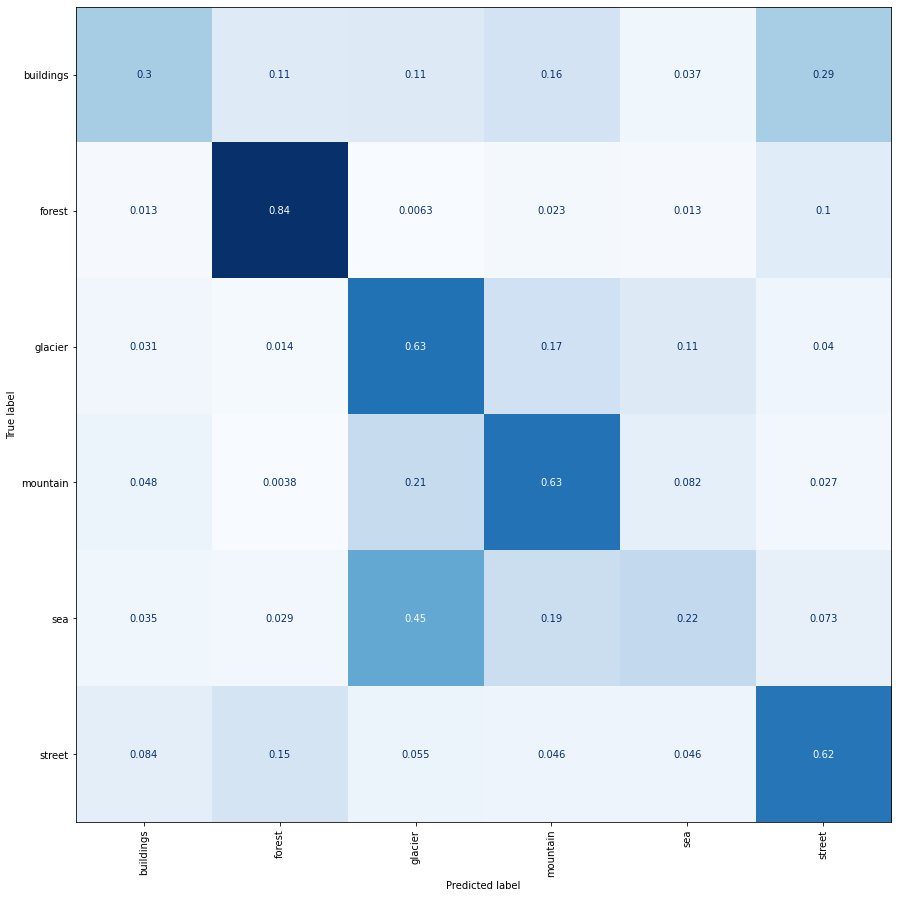

In [59]:
compute_confusion_matrix(botnet,test_loader)

# ResNet

In [45]:
resnet50 = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

for param in resnet50.parameters():
  param.requires_grad = False

resnet50.fc = nn.Linear(2048,num_classes)
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
params_to_update = []
for name,param in resnet50.named_parameters():
        if param.requires_grad == True:
          params_to_update.append(param)
          print(name)

fc.weight
fc.bias


In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update,lr = learning_rate)

In [48]:
train_losses, val_losses = training(resnet50,train_loader,test_loader,criterion ,optimizer,epochs= 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 4.32, Validation Loss: 2.15


Epoch 2:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 3.29, Validation Loss: 2.30


Epoch 3:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 2.24, Validation Loss: 2.42


Epoch 4:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 2.89, Validation Loss: 2.47


Epoch 5:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 2.31, Validation Loss: 2.69


In [60]:
resnet_acc = inference(resnet50,test_loader)
print(f'Test Accuracy: {100 * resnet_acc:.4f}')

  0%|          | 0/93 [00:00<?, ?it/s]

Test Accuracy: 87.8696


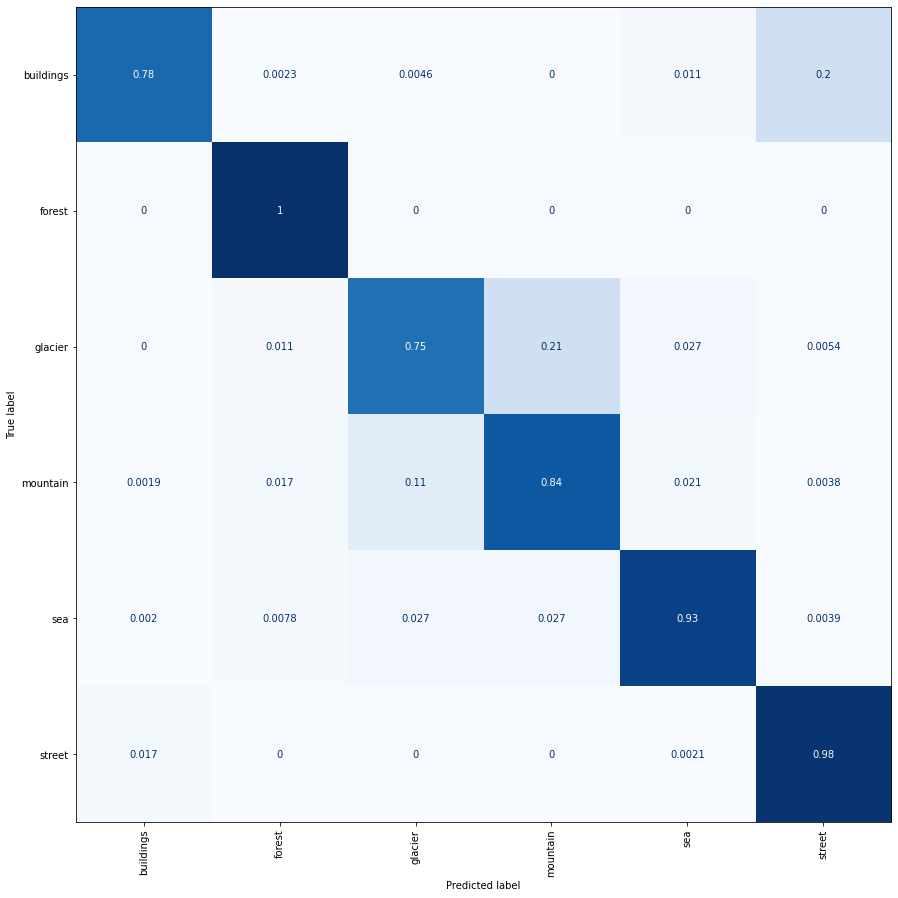

In [61]:
compute_confusion_matrix(resnet50,test_loader)

# Vision Transformer

In [50]:
vit = torchvision.models.vit_b_16(weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)
for param in vit.parameters():
    param.requires_grad = False

vit.heads = nn.Linear(768,num_classes)
vit.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16_lc_swag-4e70ced5.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_lc_swag-4e70ced5.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [51]:
params_to_update = []
for name,param in vit.named_parameters():
        if param.requires_grad == True:
          params_to_update.append(param)
          print(name)

heads.weight
heads.bias


In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update,lr = 0.001)

In [53]:
train_losses, val_losses = training(vit,train_loader,test_loader,criterion ,optimizer,epochs= 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 0.08, Validation Loss: 0.16


Epoch 2:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 0.18, Validation Loss: 0.15


Epoch 3:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 0.18, Validation Loss: 0.15


Epoch 4:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 0.14, Validation Loss: 0.15


Epoch 5:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Train Loss: 0.12, Validation Loss: 0.15


In [54]:
vit_acc = inference(vit,test_loader)
print(f'Test Accuracy: {100 * vit_acc:.4f}')

  0%|          | 0/93 [00:00<?, ?it/s]

Test Accuracy: 94.2876


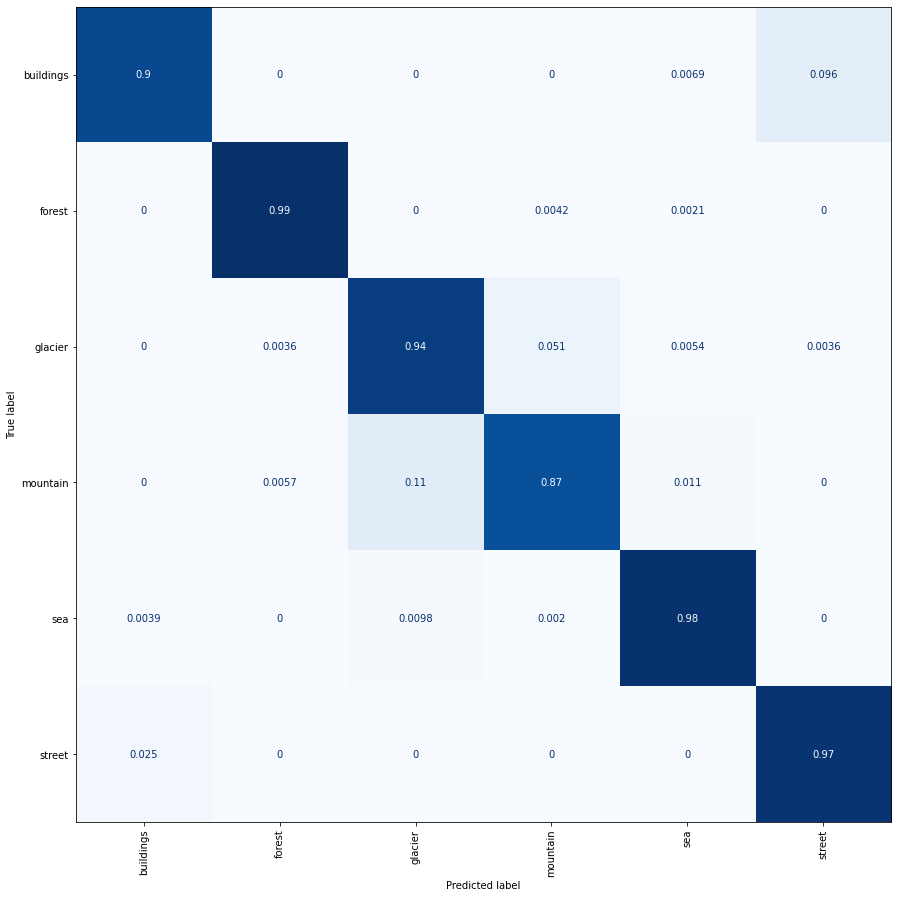

In [55]:
compute_confusion_matrix(vit,test_loader)

In [66]:
import pandas as pd

results = pd.DataFrame({"Test Accuracy":[botnet_acc,resnet_acc,vit_acc]}, index = ['BoTNet',"ResNet50","Vision Transformer"],)
results['Test Accuracy'] = results['Test Accuracy'] * 100
results['Test Accuracy'] = results['Test Accuracy'].round(decimals = 2)
results.sort_values(by='Test Accuracy', ascending=False,inplace=True)

results

,Test Accuracy
Vision Transformer,94.29
ResNet50,87.87
BoTNet,54.37
